# Academy Agent Pool Play

Framework for automated and easy local evaluation of agents against each other. 

Support different scenarios and configurations.

Goal of building this is to enable quicker insight and feedback on agent performance, so we can spend less time trying to evaluate agent performance and more time focusing on implementing different strategies 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import itertools
import time
from kaggle_environments import make
from kaggle_environments.envs.football.helpers import *
from math import sqrt
from IPython.display import HTML

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 150)

np.set_printoptions(suppress=True)


def run_pool_play(scenario_name, episode_steps, num_rounds, agents, agents_dir, export_dir, write_file=False):
    print('run pool play scenario: {0}'.format(scenario_name))
    start_time = time.time()
    
    agents_dirs = [agents_dir + x for x in agents]
    
    env_config = {
        "save_video": False,
        "scenario_name": scenario_name,
        "running_in_notebook": True,
        "episodeSteps": episode_steps
    }
    
    env = make("football", configuration=env_config, debug=False)
    
    
    df_list = []

    for pool_play_round in range(num_rounds):
        for agent1 in agents_dirs:
            for agent2 in agents_dirs:
                env.reset()
                output = env.run([agent1, agent2])

                final_output = output[-1]
                left_agent_foutput = final_output[0]
                right_agent_foutput = final_output[1]
                left_reward = left_agent_foutput['reward']
                right_reward = right_agent_foutput['reward']
                left_status = left_agent_foutput['status']
                right_status = right_agent_foutput['status']

                left_score = output[-1][0]['observation']['players_raw'][0]['score'][0]
                right_score = output[-1][0]['observation']['players_raw'][0]['score'][1]

                adf = pd.DataFrame()
                adf['scenario'] = [scenario_name]
                adf['round'] = [pool_play_round]
                adf['left_agent'] = [agent1.replace(agents_dir, '')]
                adf['right_agent'] = [agent2.replace(agents_dir, '')]
                adf['left_score'] = [left_score]
                adf['right_score'] = [right_score]
                adf['left_reward'] = [left_reward]
                adf['right_reward'] = [right_reward]
                adf['left_status'] = [left_status]
                adf['right_status'] = [right_status]

                df_list.append(adf)

        pool_play_round +=1
        
    #final dataframe with results    
    fdf = pd.concat(df_list)
    
    # write out results to file if flag set
    if write_file:
        # make export directory w/ timestamp of runs
        curr_datetime = dt.datetime.now()
        curr_time = curr_datetime.strftime('%d-%m-%Y-%H-%M-%S')
        export_fdir = export_dir + curr_time
        os.mkdir(export_fdir)

        # write out results
        export_result_file = export_fdir + '/results.csv'
        fdf.to_csv(export_result_file, index=False)
        print('results written out to {0}'.format(export_result_file))

        # write out config
        config_df = pd.DataFrame(env_config.items())
        config_df = config_df.append([['num_rounds', num_rounds]])
        config_df.to_csv(export_fdir + '/config.csv', index=False)

        end_time = round((time.time() - start_time), 2)
        print("complete: --- %s seconds ---" % end_time)
    
    # get scoreboard result dataframe
    score_df = get_scoreboard(fdf)
    # add some final columns
    score_df['scenario_name'] = scenario_name
    score_df = score_df[['scenario_name','agent', 'games_played', 'num_wins', 'num_losses', 'num_ties',
       'goals_for', 'goals_against', 'num_points']]
    
    return fdf,score_df


def get_scoreboard_from_file(result_file):
    rdf = pd.read_csv(result_file)
    score_df = get_scoreboard(rdf)
    return score_df

def get_scoreboard(rdf):
    # get only cases where valid statuses
    rdf = rdf[rdf['right_status'] == 'DONE']
    rdf = rdf[rdf['left_status'] == 'DONE']

    agents = list(set(list(rdf.left_agent.unique()) + list(rdf.right_agent.unique())))
    
    result_list = []

    for agent in agents:
        left_df = rdf[rdf.left_agent == agent].reset_index(drop=True)

        # calculate num_wins, num_losses, num_ties
        left_df['num_wins'] = np.where(left_df['left_score'] > left_df['right_score'], 1, 0)
        left_df['num_losses'] = np.where(left_df['left_score'] < left_df['right_score'], 1, 0)
        left_df['num_ties'] = np.where(left_df['left_score'] == left_df['right_score'], 1, 0)

        games_played = len(left_df)
        goals_for = left_df.left_score.sum()
        goals_against = left_df.right_score.sum()
        num_wins = left_df.num_wins.sum()
        num_losses = left_df.num_losses.sum()
        num_ties = left_df.num_ties.sum()


        right_df = rdf[rdf.right_agent == agent].reset_index(drop=True)

        # calculate num_wins, num_losses, num_ties
        right_df['num_wins'] = np.where(right_df['right_score'] > right_df['left_score'], 1, 0)
        right_df['num_losses'] = np.where(right_df['right_score'] < right_df['left_score'], 1, 0)
        right_df['num_ties'] = np.where(right_df['right_score'] == right_df['left_score'], 1, 0)

        games_played = games_played + len(right_df)
        goals_for = goals_for + right_df.right_score.sum()
        goals_against = goals_against + right_df.left_score.sum()
        num_wins = num_wins + right_df.num_wins.sum()
        num_losses = num_losses + right_df.num_losses.sum()
        num_ties = num_ties + right_df.num_ties.sum()

        result_list.append([agent, games_played, num_wins, num_losses, num_ties, goals_for, goals_against])

    fdf = pd.DataFrame(result_list, columns = ['agent', 'games_played', 'num_wins', 'num_losses', 'num_ties',
                                               'goals_for', 'goals_against'])

    fdf['num_points'] = fdf['num_wins']*3 + fdf['num_ties']*1

    fdf = fdf.sort_values('num_points', ascending=False)
    
    return fdf

## Testing

In [2]:
AGENTS_DIR = '../submit_agents/'
EXPORT_DIR = 'pool_play_results/'
NUM_ROUNDS = 3

AGENTS = [
    'tunable-baseline-bot/submission_v6.py',
    'best-open-rules-bot/submission_v2.py',
    'gfootball-with-memory-patterns/submission_v15.py',
    'gfootball-with-memory-patterns/submission_v28.py',
    'gfootball-with-memory-patterns/submission_v32.py',
]

EPISODE_STEPS = 500

SCENARIO_NAME = 'academy_custom'

In [3]:
result_df, score_df = run_pool_play(SCENARIO_NAME, EPISODE_STEPS, NUM_ROUNDS, AGENTS, AGENTS_DIR, EXPORT_DIR, write_file=False)

run pool play scenario: academy_custom


In [4]:
result_df.head()

,scenario,round,left_agent,right_agent,left_score,right_score,left_reward,right_reward,left_status,right_status
0,academy_custom,0,tunable-baseline-bot/submission_v6.py,tunable-baseline-bot/submission_v6.py,1,0,1,-1,DONE,DONE
0,academy_custom,0,tunable-baseline-bot/submission_v6.py,best-open-rules-bot/submission_v2.py,0,0,0,0,DONE,DONE
0,academy_custom,0,tunable-baseline-bot/submission_v6.py,gfootball-with-memory-patterns/submission_v15.py,1,0,1,-1,DONE,DONE
0,academy_custom,0,tunable-baseline-bot/submission_v6.py,gfootball-with-memory-patterns/submission_v28.py,1,0,1,-1,DONE,DONE
0,academy_custom,0,tunable-baseline-bot/submission_v6.py,gfootball-with-memory-patterns/submission_v32.py,1,0,1,-1,DONE,DONE


Test from file

In [5]:
score_df = get_scoreboard_from_file('./pool_play_results/07-11-2020-19-42-17/results.csv')

In [6]:
score_df

,agent,games_played,num_wins,num_losses,num_ties,goals_for,goals_against,num_points
3,tunable-baseline-bot/submission_v6.py,12,8,0,4,8,0,28
0,gfootball-with-memory-patterns/submission_v28.py,12,3,1,8,3,1,17
4,best-open-rules-bot/submission_v2.py,12,3,1,8,3,1,17
2,gfootball-with-memory-patterns/submission_v15.py,12,0,5,7,0,5,7
1,gfootball-with-memory-patterns/submission_v32.py,12,0,7,5,0,7,5


## Trying running multiple different scenarios

In [7]:
AGENTS_DIR = '../submit_agents/'
EXPORT_DIR = 'pool_play_results/'
NUM_ROUNDS = 3

AGENTS = [
    'tunable-baseline-bot/submission_v6.py',
    'best-open-rules-bot/submission_v2.py',
    'gfootball-with-memory-patterns/submission_v15.py',
    'gfootball-with-memory-patterns/submission_v28.py',
    'gfootball-with-memory-patterns/submission_v32.py',
]

EPISODE_STEPS = 500

In [8]:
%%time
score_df_list = []
result_df_list = []

scenarios = [
    'academy_3_vs_1_with_keeper', 
    'academy_empty_goal_close'
]

for scenario in scenarios:
    result_df, score_df = run_pool_play(scenario, EPISODE_STEPS, NUM_ROUNDS, AGENTS, AGENTS_DIR, EXPORT_DIR, write_file=False)
    score_df_list.append(score_df)
    result_df_list.append(result_df)

scen_scores_df = pd.concat(score_df_list)
scen_results_df = pd.concat(result_df_list)

run pool play scenario: academy_3_vs_1_with_keeper
run pool play scenario: academy_empty_goal_close
CPU times: user 44.2 s, sys: 439 ms, total: 44.7 s
Wall time: 45.2 s


In [9]:
scen_scores_df

,scenario_name,agent,games_played,num_wins,num_losses,num_ties,goals_for,goals_against,num_points
1,academy_3_vs_1_with_keeper,gfootball-with-memory-patterns/submission_v32.py,30,6,2,22,6,2,40
3,academy_3_vs_1_with_keeper,tunable-baseline-bot/submission_v6.py,30,4,4,22,4,4,34
0,academy_3_vs_1_with_keeper,gfootball-with-memory-patterns/submission_v28.py,30,3,4,23,3,4,32
4,academy_3_vs_1_with_keeper,best-open-rules-bot/submission_v2.py,30,2,3,25,2,3,31
2,academy_3_vs_1_with_keeper,gfootball-with-memory-patterns/submission_v15.py,30,2,4,24,2,4,30
0,academy_empty_goal_close,gfootball-with-memory-patterns/submission_v28.py,30,15,15,0,15,15,45
1,academy_empty_goal_close,gfootball-with-memory-patterns/submission_v32.py,30,15,15,0,15,15,45
2,academy_empty_goal_close,gfootball-with-memory-patterns/submission_v15.py,30,15,15,0,15,15,45
3,academy_empty_goal_close,tunable-baseline-bot/submission_v6.py,30,15,15,0,15,15,45
4,academy_empty_goal_close,best-open-rules-bot/submission_v2.py,30,15,15,0,15,15,45


In [10]:
scen_results_df.head(2)

,scenario,round,left_agent,right_agent,left_score,right_score,left_reward,right_reward,left_status,right_status
0,academy_3_vs_1_with_keeper,0,tunable-baseline-bot/submission_v6.py,tunable-baseline-bot/submission_v6.py,0,0,0,0,DONE,DONE
0,academy_3_vs_1_with_keeper,0,tunable-baseline-bot/submission_v6.py,best-open-rules-bot/submission_v2.py,0,0,0,0,DONE,DONE


## Checking out scenario runs of interest

In [11]:
def agent_run(left_agent, right_agent, debug, config):
    env = make("football", debug=debug, configuration=config)
         
    output = env.run([left_agent, right_agent])
    print('SCENARIO TYPE: {0}'.format(config['scenario_name']))
    print(left_agent + ' vs '+ right_agent)
    scores = output[-1][0][
        "observation"]["players_raw"][0]["score"]
    print("Scores  {0} : {1}".format(*scores))
    print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))
    print('number of steps: {0}'.format(len(output)))
    return output

In [12]:
CONFIG={
    "save_video": False, 
    "scenario_name": "academy_3_vs_1_with_keeper", 
    "running_in_notebook": True
}

DEBUG = False

LEFT_AGENT = "../submit_agents/gfootball-with-memory-patterns/submission_v15.py"
RIGHT_AGENT = "../submit_agents/gfootball-with-memory-patterns/submission_v32.py"

Run the scenario

In [13]:
%%time
output = agent_run(LEFT_AGENT, RIGHT_AGENT, DEBUG, CONFIG)

SCENARIO TYPE: academy_3_vs_1_with_keeper
../submit_agents/gfootball-with-memory-patterns/submission_v15.py vs ../submit_agents/gfootball-with-memory-patterns/submission_v32.py
Scores  0 : 0
Rewards 0 : 0
number of steps: 26
CPU times: user 668 ms, sys: 39.8 ms, total: 708 ms
Wall time: 711 ms


get run metrics

get_match_metrics

Visualize run result

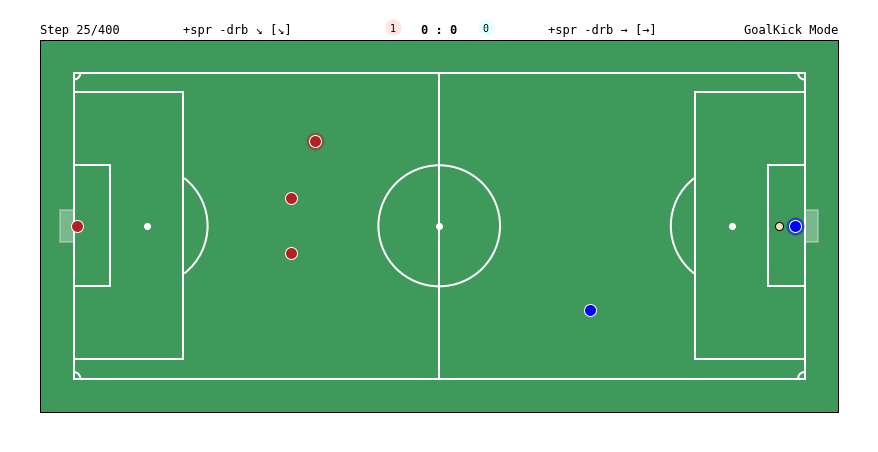

In [19]:
from visualizer import visualize
viz = visualize(output)
HTML(viz.to_html5_video())

Interesting, we can see the issue here is shooting accuracy and direction. Now we can make changes to our bot, run the scenarios again and see if the results for the specifc scenario improve.

You can run against different scenarios as well, to ensure no regression issue in other areas of your game